(5000, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Fever      5000 non-null   float64
 1   Headache   5000 non-null   float64
 2   Cough      5000 non-null   float64
 3   Fatigue    5000 non-null   float64
 4   Body_Pain  5000 non-null   float64
 5   Disease    5000 non-null   object 
dtypes: float64(5), object(1)
memory usage: 234.5+ KB
None
Fever        0
Headache     0
Cough        0
Fatigue      0
Body_Pain    0
Disease      0
dtype: int64


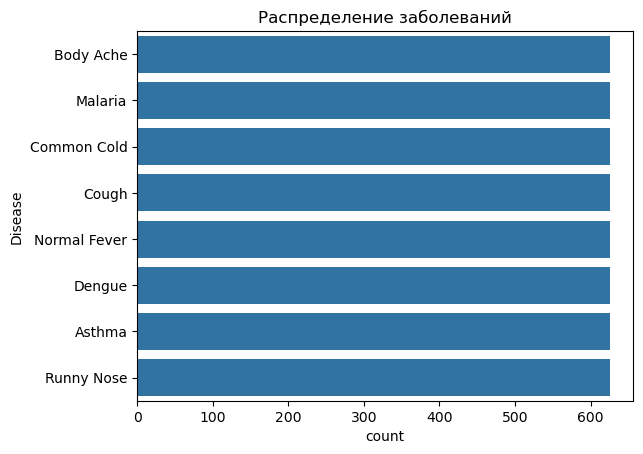

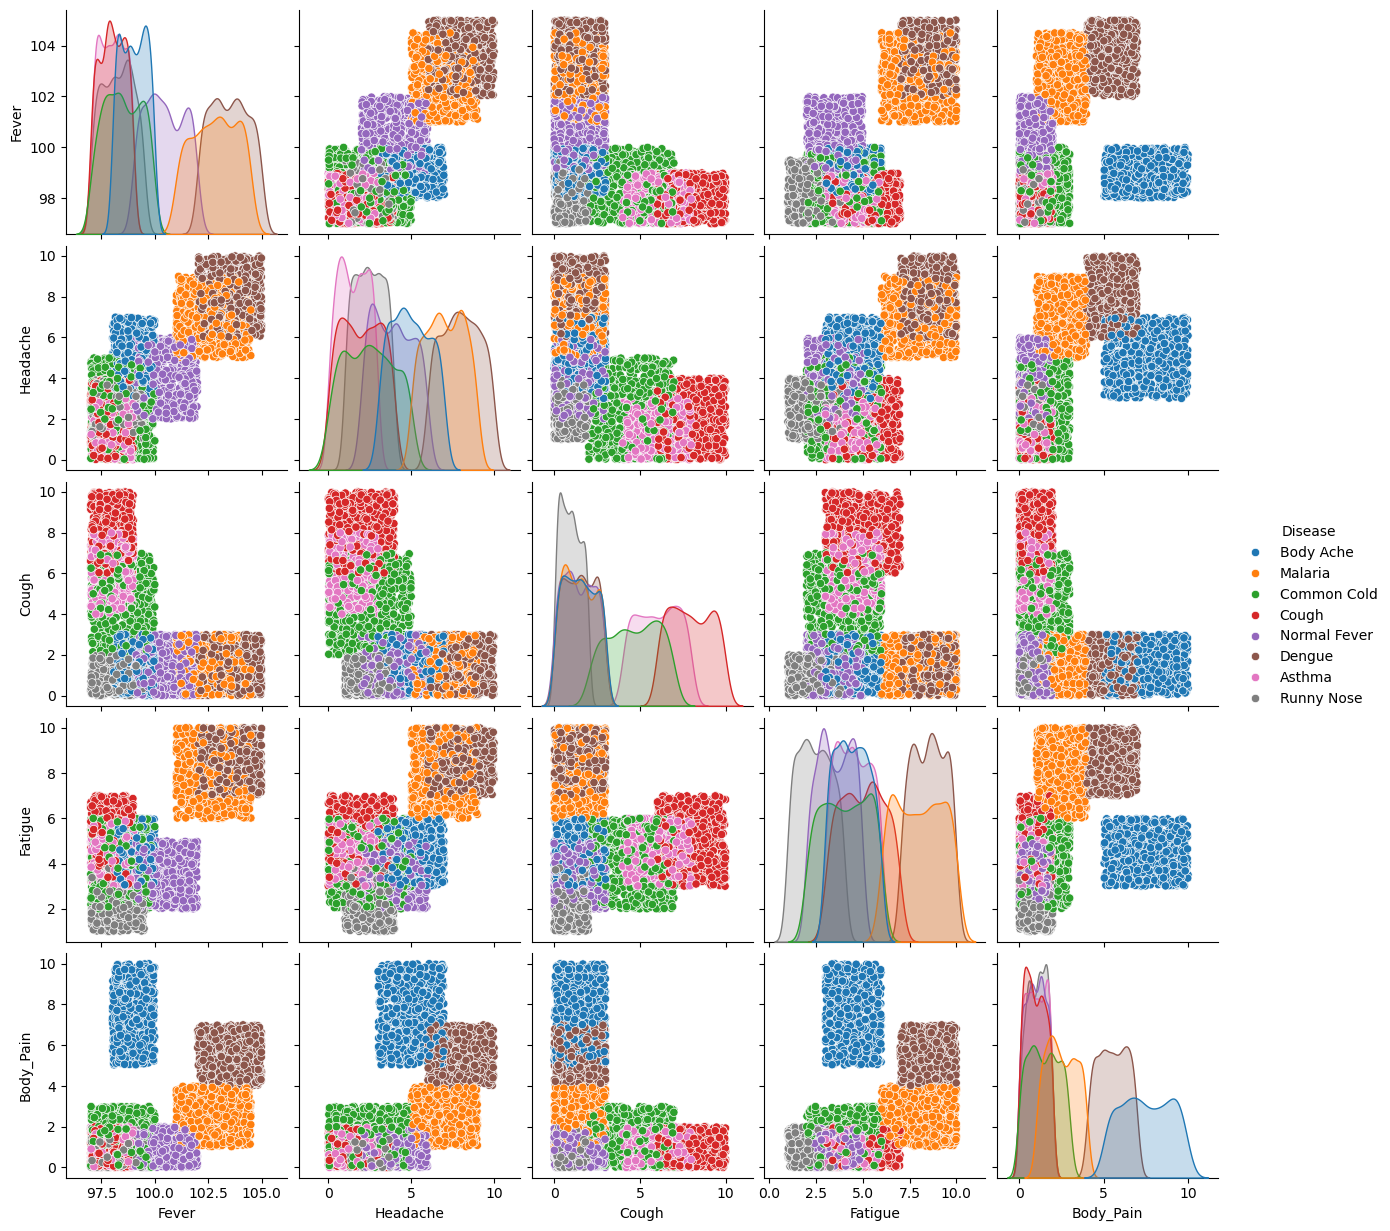

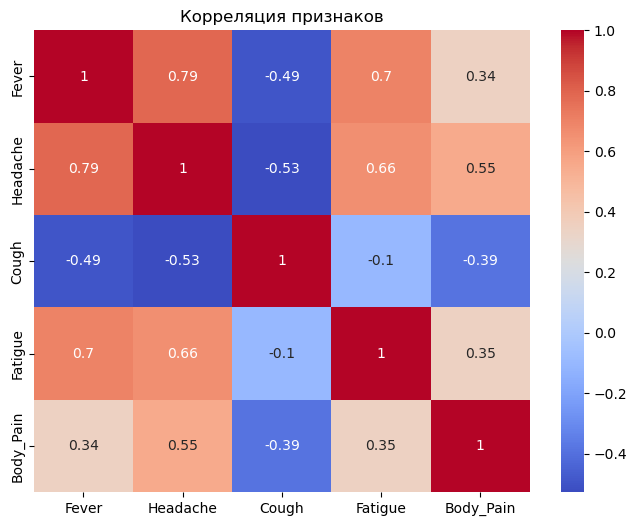

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:53:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:53:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:53:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:53:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

📊 Итоговая таблица сравнения моделей:


,Accuracy,F1 Macro,ROC AUC
Random Forest Optimized,0.928,0.929018,0.992595
XGBoost Optimized,0.926,0.926847,0.992998
Random Forest,0.919,0.920275,0.992132
Gradient Boosting,0.918,0.919088,0.991914
XGBoost,0.910,0.911252,0.991746
Decision Tree,0.901,0.902073,0.943429
Logistic Regression,0.878,0.877918,0.985857


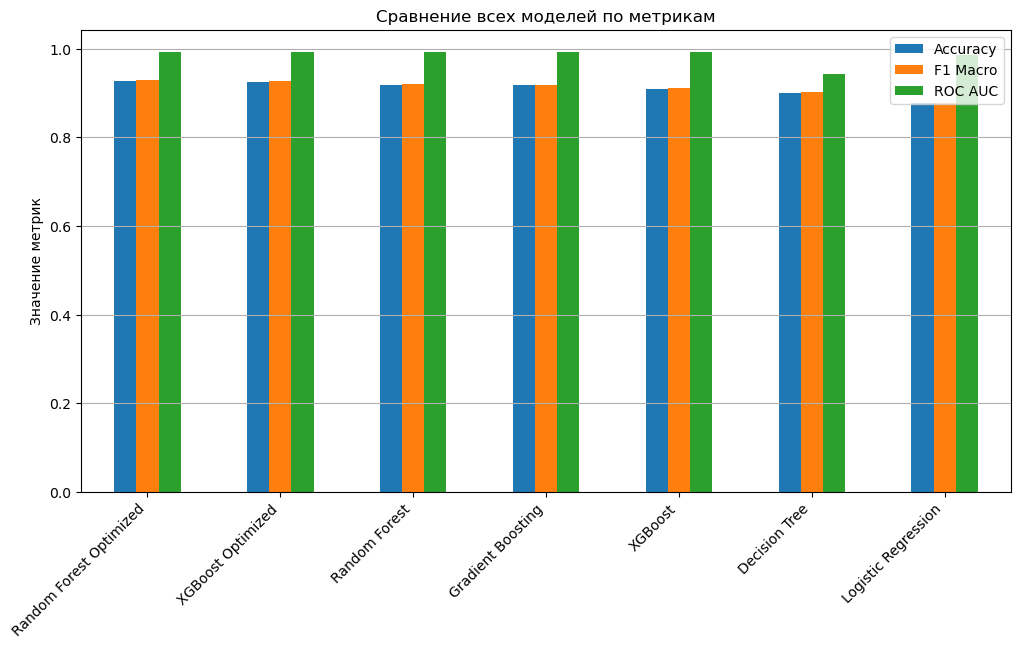

🏆 Лучшая модель по F1 Macro: Random Forest Optimized


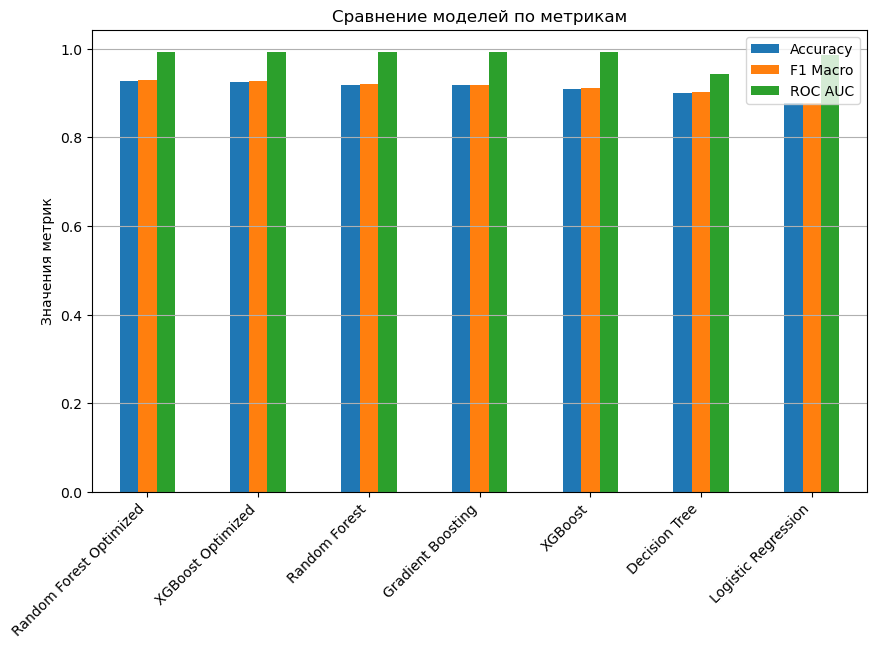

Лучшая модель: Random Forest Optimized
Accuracy    0.928000
F1 Macro    0.929018
ROC AUC     0.992595
Name: Random Forest Optimized, dtype: float64


In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# 1. Загрузка и предварительный анализ данных
df = pd.read_csv('/Users/arhipshapovalov/Downloads/dataset1.csv')  # Укажите путь к вашему файлу
print(df.shape)
df.head()

# 2. EDA - разведочный анализ
print(df.info())
print(df.isnull().sum())

sns.countplot(y='Disease', data=df)
plt.title('Распределение заболеваний')
plt.show()

sns.pairplot(df, hue='Disease')
plt.show()

# 3. Корреляционный анализ
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Корреляция признаков')
plt.show()

# 4. Подготовка данных
X = df.drop('Disease', axis=1)
y = df['Disease']

# Кодирование целевой переменной
le = LabelEncoder()
y_enc = le.fit_transform(y)

# Масштабирование
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Разделение выборок
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_enc, test_size=0.2, stratify=y_enc, random_state=42)

# 5. Базовые модели (5 моделей, 2 ансамблевых)
models = {
    'Logistic Regression': LogisticRegression(max_iter=500),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
}

# 6. Обучение базовых моделей и оценка
baseline_results = {}

for name, clf in models.items():
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    proba = clf.predict_proba(X_test)
    baseline_results[name] = {
        'Accuracy': accuracy_score(y_test, preds),
        'F1 Macro': f1_score(y_test, preds, average='macro'),
        'ROC AUC': roc_auc_score(y_test, proba, multi_class='ovr')
    }

pd.DataFrame(baseline_results).T

# 7. Гиперпараметры и оптимизация для ансамблевых моделей
param_grids = {
    'Random Forest': {'n_estimators': [100, 200], 'max_depth': [None, 10, 20]},
    'XGBoost': {'n_estimators': [100, 200], 'max_depth': [3, 6], 'learning_rate': [0.01, 0.1]}
}

optimized_results = {}
best_models = {}

for name in param_grids:
    grid = GridSearchCV(models[name], param_grids[name], cv=3, scoring='f1_macro', n_jobs=-1)
    grid.fit(X_train, y_train)
    best_models[name] = grid.best_estimator_

    preds = best_models[name].predict(X_test)
    proba = best_models[name].predict_proba(X_test)

    optimized_results[name + ' Optimized'] = {
        'Accuracy': accuracy_score(y_test, preds),
        'F1 Macro': f1_score(y_test, preds, average='macro'),
        'ROC AUC': roc_auc_score(y_test, proba, multi_class='ovr')
    }

# 8. Сравнение всех моделей
# Объединение базовых и оптимизированных результатов
final_results = {**baseline_results, **optimized_results}

# Преобразование в таблицу DataFrame
results_df = pd.DataFrame(final_results).T

# Сортировка по F1 Macro (можно по другой метрике)
results_df_sorted = results_df.sort_values('F1 Macro', ascending=False)

# Чёткий вывод таблицы
print("Итоговая таблица сравнения моделей:")
display(results_df_sorted)

# Визуализация сравнения по трём метрикам
results_df_sorted[['Accuracy', 'F1 Macro', 'ROC AUC']].plot.bar(figsize=(12,6))
plt.title('Сравнение всех моделей по метрикам')
plt.ylabel('Значение метрик')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.show()

# Лучшая модель
print(f"Лучшая модель по F1 Macro: {results_df_sorted.index[0]}")

# 9. Визуализация итогов
results_df_sorted[['Accuracy', 'F1 Macro', 'ROC AUC']].plot.bar(figsize=(10,6))
plt.title('Сравнение моделей по метрикам')
plt.ylabel('Значения метрик')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.show()

# 10. Выводы
best_model = results_df_sorted.iloc[0]
print(f"Лучшая модель: {results_df_sorted.index[0]}")
print(best_model)
